# Neural Network
----------

## Importing libraries

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Loading data

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() 

#### Bringing the values in the range between 0 and 1

In [16]:
x_train = x_train / 255.0
x_test = x_test / 255.0

## Visualising data

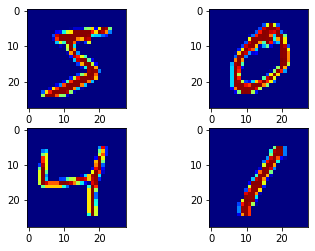

In [17]:
for i in range(4):
    plt.subplot(221 + int(i))
    plt.imshow(x_train[i], cmap = plt.get_cmap('jet'))

## Normalizing Data

In [18]:
x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

## Model

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(784,)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=1024)

Epoch 1/20
59/59 [==============================] - 1s 16ms/step - loss: 2.1615 - accuracy: 0.4072 - val_loss: 1.9634 - val_accuracy: 0.5738
Epoch 2/20
59/59 [==============================] - 1s 14ms/step - loss: 1.7704 - accuracy: 0.6291 - val_loss: 1.5599 - val_accuracy: 0.6956
Epoch 3/20
59/59 [==============================] - 1s 12ms/step - loss: 1.3772 - accuracy: 0.7166 - val_loss: 1.1901 - val_accuracy: 0.7597
Epoch 4/20
59/59 [==============================] - 1s 13ms/step - loss: 1.0540 - accuracy: 0.7843 - val_loss: 0.9198 - val_accuracy: 0.8251
Epoch 5/20
59/59 [==============================] - 1s 11ms/step - loss: 0.8310 - accuracy: 0.8392 - val_loss: 0.7408 - val_accuracy: 0.8585
Epoch 6/20
59/59 [==============================] - 1s 11ms/step - loss: 0.6823 - accuracy: 0.8659 - val_loss: 0.6189 - val_accuracy: 0.8764
Epoch 7/20
59/59 [==============================] - 1s 10ms/step - loss: 0.5778 - accuracy: 0.8818 - val_loss: 0.5305 - val_accuracy: 0.8877
Epoch 8/20
59

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


#### Saving the model

model.save('model.h5')

# Server Setup

In [22]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import os
import random
import string

from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(model.inputs, [layer.output for layer in model.layers])

_, (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index,:,:]
    image_arr = np.reshape(image, (1, 784))
    return feature_model.predict(image_arr), image

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        preds, image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({'prediction': final_preds, 'image': image.tolist()})
    return 'Welcome to the ml server'

if __name__ == '__main__':
    app.run()


Overwriting ml_server.py


# Streamlit Web App

In [23]:
%%writefile app.py

import requests
import json
import numpy as np
import streamlit as st
import os
import matplotlib.pyplot as plt

URI = 'http://127.0.0.1:5000'

st.title('Neural Network Visualizer')
st.sidebar.markdown('# Input Image')

if st.button('Get random predictions'):
    response = requests.post(URI, data={})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image, (28, 28))

    st.sidebar.image(image, width=150)

    for layer, p in enumerate(preds):
        numbers = np.squeeze(np.array(p))

        plt.figure(figsize=(32, 4))

        if layer == 2:
            row = 1
            col = 10
        else:
            row = 2
            col = 16

        for i, number in enumerate(numbers):
            plt.subplot(row, col, i + 1)
            plt.imshow((number * np.ones((8, 8, 3))).astype('float32'), cmap='binary')
            plt.xticks([])
            plt.yticks([])
            if layer == 2:
                plt.xlabel(str(i), fontsize=40)
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.tight_layout()

        st.text('Layer {}'.format(layer + 1), )
        st.pyplot()


Overwriting app.py


Open 2 terminals where you have all these files stored and run the following commands in the respective windows-
* python3 ml_server.py    
* streamlit run app.py  
  
This will open up a tab in your browser from where you can visualise your neural network